---

## IML - Homework 5

### *Agata Pałdyna*

---

## Dataset: Medical Expenditure Panel Survey

## Method: **Feature Importance**

---

## 1) Key results and comments

Problem polega na predycji wydatków na opiekę zdrowotną osób fizycznych. Zbiór danych zawiera dane pochodzące z sondaży. Zmienne opisują status demograficzny i społeczno-ekonomiczny ankietowanych osób, jak również diagnozy chorób, ograniczenia zdrowotne oraz zgłoszony przez nich stan zdrowia. <br/>
Zbudowany model to **Gradient Boosting Regressor**, zaimplementowany w pakiecie scikit-learn. Zmienne kategoryczne (tj. zmienne, które mają co najwyżej 10 unikalnych wartości - nie dotyczy zmiennych "POVCAT15", "RTHLTH31", "MNHLTH31", które mogą być traktowane jak ciągłe) zostały przekształcone za pomocą kodowania one-hot. Zmienna celu została przekształcona za pomocą logarytmu o podstawie 3.

### ad 2)


Dla zbudowanego modelu obliczona została permutacyjna ważność zmiennych za pomocą funkcji `permutation_importance()` z pakietu scikit-learn. Boxploty dziesięciu najważniejszych zmiennych zostały przedstawione na poniższym wykresie. Jak widać, zdecydowanie najważniejszą zmienną jest zmienna **INSCOV15**, która oznacza wskaźnik zakresu ubezpieczenia zdrowotnego w 2015 roku i przyjmuje wartości 1, 2, 3, które oznaczają odpowiednio dowolne prywatne, tylko publiczne, nieubezpieczony. Kolejne, około dwukrotnie mniej ważne zmienne to RACE3, HIBPDX (która oznacza diagnozę wysokiego ciśnienia krwi i przyjmuje wartości -1, 1, 2, które oznaczają odpowiednio niedotyczy, tak, nie), CHOLDX (która oznacza diagnozę wysokiego cholesterolu i przyjmuje wartości -1, 1, 2, które oznaczają odpowiednio niedotyczy, tak, nie).

<img src="images/pvi01.png">

### ad 3)


Kolejne dwa modele zostały zbudowane podobnie jak bazowy. Różnicą było dodanie skalowania zmiennych liczbowych. W jednym modelu został użyty **StandardScaler**, natomiast w drugim **MinMaxScaler**. <br/>
Wyniki permutacyjnej ważności zmiennych nie różnią się pomiędzy tymi dwoma skalowaniami, różnią się natomiast w porównaniu z bazowym modelem. Co prawda, nadal najważniejszą zmienną jest **INSCOV15**, jednak w przypadku dodania skalowania jej ważność zmalała o około 0.01. Na kolejnych dwóch miejscach pojawiły się zmienne, które wcześniej dla bazowego modelu nie występowały w najważniejszej dziesiątce: PCS42, AGE31X (która oznacza wiek pacjenta), a zmienna RACE3 spadła z drugiego na czwarte miejsce. Z pozostałych zmiennych w rankingu połowa jest nowa, a druga połowa spadła w porównaniu z rankingiem dla bazowego modelu. <br/>
Wszystkie zmienne, które pojawiły się w najważniejszej dziesiątce, za wyjątkiem zmiennej PREGNT31 (która oznacza czy pacjent jest w ciąży i przyjmuje wartości -1, 1, 2, które oznaczają odpowiednio niedotyczy, tak, nie) są zmiennymi ciągłymi. W rankingu bazowego modelu znajdowały się tylko zmienne kategoryczne.

<img src="images/pvi02.png" align="left" width="50%"/><img src="images/pvi03.png" align="right" width="50%"/>

Kolejne dwa modele to **Random Forest Regressor** oraz **Linear Regression**, oba ze skalowaniem **StandardScaler**. <br/>
Ranking dziesięciu najważniejszych zmiennych dla modelu Random Forest Regressor zawiera większość zmiennych, które pojawiły się w rankingu dla modelu Gradient Boosting Regressor ze skalowaniem. Zmienne te występują w nieco innej kolejności i dają wyniki innego rzędu (10 razy większe). W przypadku tego modelu najważniejszą zmienną okazała się zmienna **AGE31X**. <br/>
Ranking dziesięciu najważniejszych zmiennych dla modelu regresji liniowej natomiast wygląda zupełnie inaczej: wyniki są innego rzędu, występują zmienne które nie występowały w poprzednich rankingach. Tutaj najważniejszą zmienną okazała się być zmienna **EMPST31**, która oznacza status zatrudnienia i przyjmuje wartości -1, 1, 2, które oznaczają odpowiednio nie dotyczy, zatrudniony, nie pracował w określonym czasie ale ma pracę do której wróci po tym określonym czasie. Dla regresji liniowej wszystkie zmienne w rankingu są kategoryczne.

<img src="images/pvi04.png" align="left" width="50%"/><img src="images/pvi05.png" align="right" width="50%"/>

---

## 2) Appendix

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

---

### Functions

In [2]:
def transform_target_log3(data, target_name):
    val = data[target_name].values 
    return np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val])


def get_categorical_features(data, not_cat_cols_list):
    num_unique = data.nunique()
    categorical_features = num_unique[num_unique <= 10].index.tolist()
    # Remove variables from categorical features list that can be treated as continuous
    for col in not_cat_cols_list:
        categorical_features.remove(col)
    return categorical_features


def print_model_results(y_train, y_pred_train, y_test, y_pred_test):
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    
    print("Training: \nRMSE: ", rmse_train, " | MAE: ", mean_absolute_error(y_train, y_pred_train), " | R^2: ", r2_score(y_train, y_pred_train), "\n")
    print("Test: \nRMSE: ", rmse_test, " | MAE: ", mean_absolute_error(y_test, y_pred_test), " | R^2: ", r2_score(y_test, y_pred_test), "\n")


def calculate_pvi(model, X, y):
    return permutation_importance(model, X, y, n_repeats = 10, random_state = 123)


def plot_pvi_boxplots(pvi, n, data, model_name, img_path):
    pvi_sorted_idx = pvi.importances_mean.argsort()
    plt.figure(figsize = (10, 8))
    title = "Permutational variable importance for \n" + model_name
    plt.title(title, size = 14, fontweight = "bold")
    plt.grid()
    plt.boxplot(pvi.importances[pvi_sorted_idx][-n:].T, vert = False, labels = data.columns[pvi_sorted_idx][-n:])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.savefig(img_path + ".png")
    plt.show()

---

### Read and explore data

In [3]:
data = pd.read_csv("./../dane/MEPS_data_preprocessed.csv")
data.drop(columns = ["PANEL", "PERSONWT"], inplace = True) # this variables not meant to be predictive

In [4]:
data.head()

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP
0,2,52,0.0,0.0,5,13,-1,2,2,4,...,2,25.93,58.47,3,0,4,1,2,11390.0,46612
1,2,55,1.0,0.0,3,14,-1,2,2,4,...,2,20.42,26.57,17,6,4,3,2,11390.0,9207
2,2,22,1.0,0.0,5,13,3,2,2,1,...,2,53.12,50.33,7,0,1,2,2,18000.0,808
3,2,2,0.0,0.0,6,-1,-1,3,3,1,...,-1,-1.00,-1.00,-1,-1,-1,2,2,385.0,2721
4,3,25,1.0,0.0,1,14,-1,2,2,1,...,2,59.89,45.91,9,2,1,3,1,3700.0,1573


In [5]:
data.shape

(18350, 44)

In [6]:
# Check columns types and if there are any missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18350 entries, 0 to 18349
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   REGION     18350 non-null  int64  
 1   AGE31X     18350 non-null  int64  
 2   GENDER     18350 non-null  float64
 3   RACE3      18350 non-null  float64
 4   MARRY31X   18350 non-null  int64  
 5   EDRECODE   18350 non-null  int64  
 6   FTSTU31X   18350 non-null  int64  
 7   ACTDTY31   18350 non-null  int64  
 8   HONRDC31   18350 non-null  int64  
 9   RTHLTH31   18350 non-null  int64  
 10  MNHLTH31   18350 non-null  int64  
 11  HIBPDX     18350 non-null  int64  
 12  CHDDX      18350 non-null  int64  
 13  ANGIDX     18350 non-null  int64  
 14  MIDX       18350 non-null  int64  
 15  OHRTDX     18350 non-null  int64  
 16  STRKDX     18350 non-null  int64  
 17  EMPHDX     18350 non-null  int64  
 18  CHBRON31   18350 non-null  int64  
 19  CHOLDX     18350 non-null  int64  
 20  CANCER

In [7]:
# Check number of unique values in columns
num_unique = data.nunique()
num_unique

REGION          4
AGE31X         86
GENDER          2
RACE3           2
MARRY31X       10
EDRECODE        7
FTSTU31X        4
ACTDTY31        4
HONRDC31        4
RTHLTH31        6
MNHLTH31        6
HIBPDX          3
CHDDX           3
ANGIDX          3
MIDX            3
OHRTDX          3
STRKDX          3
EMPHDX          3
CHBRON31        3
CHOLDX          3
CANCERDX        3
DIABDX          3
JTPAIN31        3
ARTHDX          3
ARTHTYPE        4
ASTHDX          3
ADHDADDX        3
PREGNT31        3
WLKLIM31        3
ACTLIM31        3
SOCLIM31        3
COGLIM31        3
DFHEAR42        3
DFSEE42         3
ADSMOK42        3
PCS42        3208
MCS42        3177
K6SUM42        27
PHQ242          8
EMPST31         5
POVCAT15        5
INSCOV15        3
INCOME_M     6553
HEALTHEXP    7424
dtype: int64

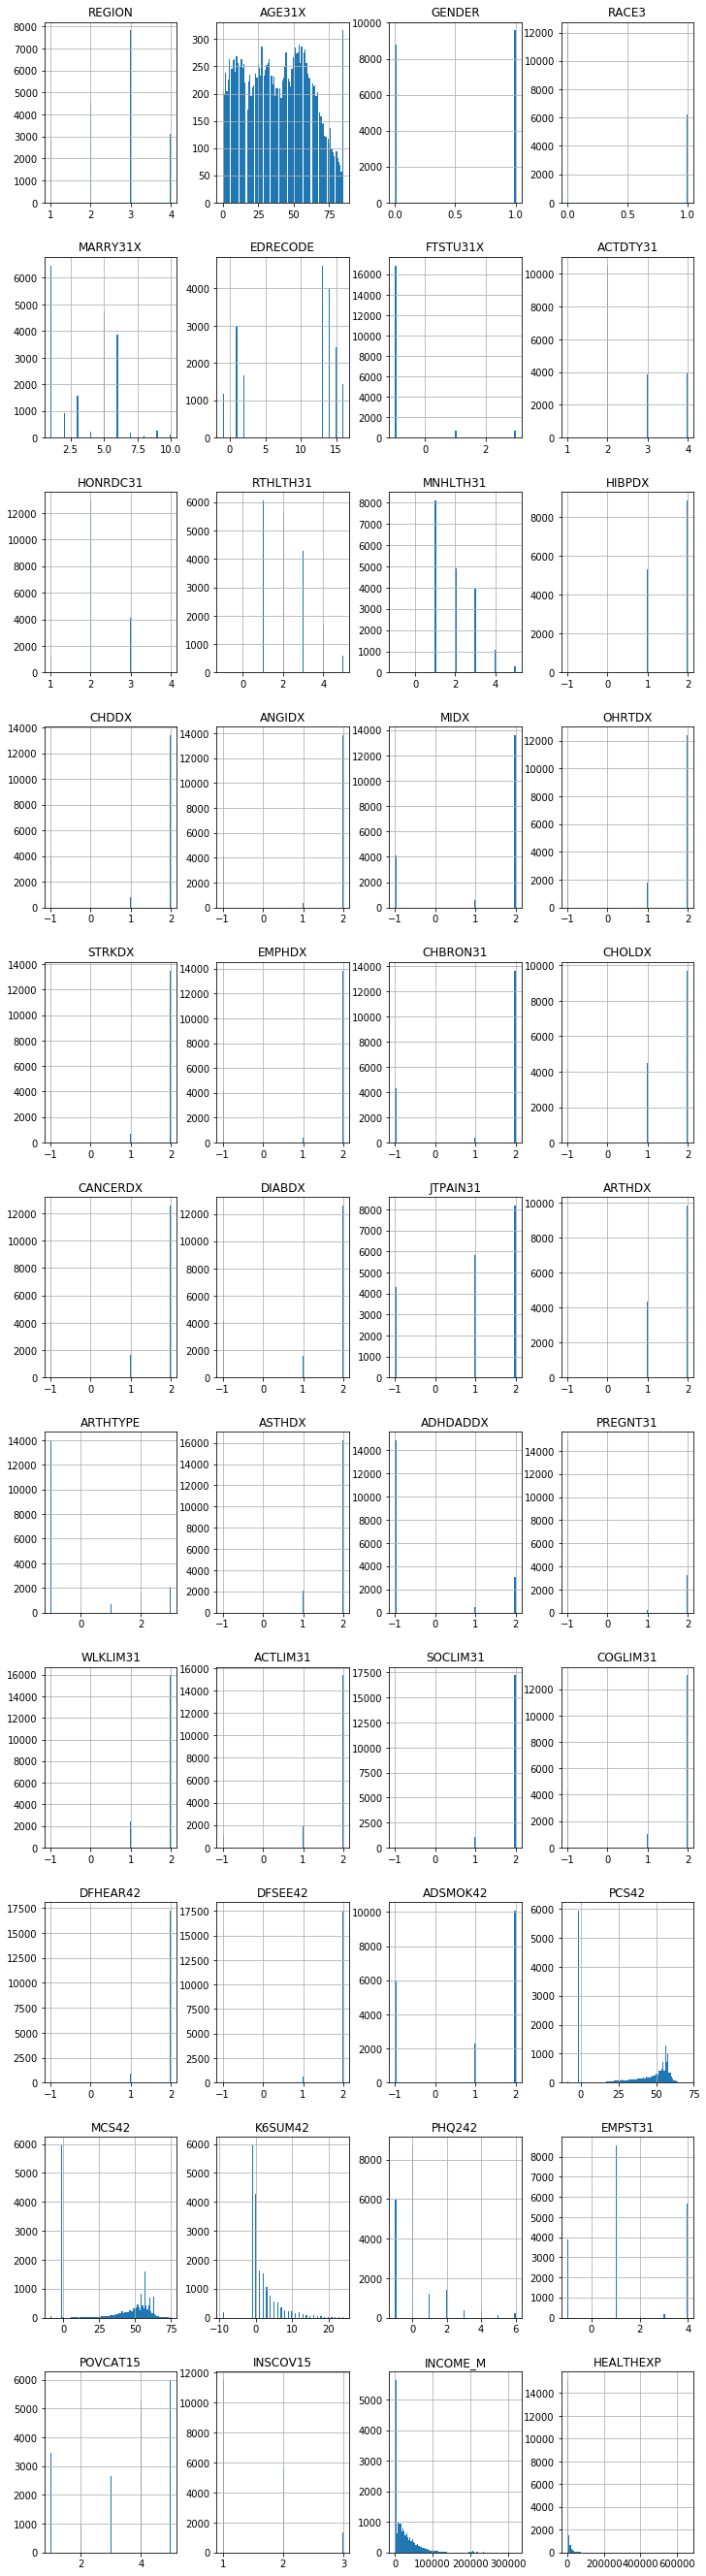

In [8]:
# Check histograms of all variables

fig, axes = plt.subplots(11, 4, figsize = (12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        data.hist(column = data.columns[i], bins = 100, ax = axis)
        i += 1
        
plt.show()

In [9]:
# Check descriptive statistics of target variable
data["HEALTHEXP"].describe()

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
25%         198.000000
50%        1034.000000
75%        4219.500000
max      659952.000000
Name: HEALTHEXP, dtype: float64

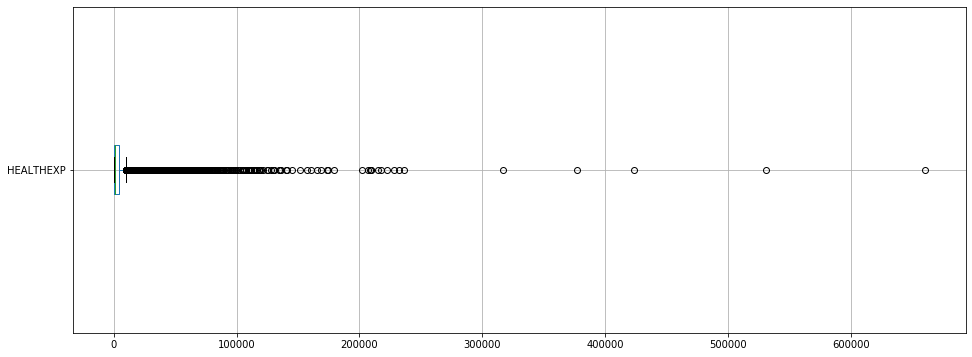

In [10]:
# Check boxplot of target variable
plt.figure(figsize = (16, 6))
data[["HEALTHEXP"]].boxplot(vert = False)
plt.show()

In [11]:
# Target variable has a long tail, hence logarithmic transformation of it.
# I use log with base 3 because it is near to e and natural logarithm is 
# good but it could be difficult to interpret the results.
data["HEALTHEXP"] = transform_target_log3(data, "HEALTHEXP")

In [12]:
# Check descriptive statistics of target variable after logarithmic transformation
data["HEALTHEXP"].describe()

count    18350.000000
mean         5.715444
std          2.756038
min          0.000000
25%          4.813588
50%          6.318143
75%          7.598196
max         12.197135
Name: HEALTHEXP, dtype: float64

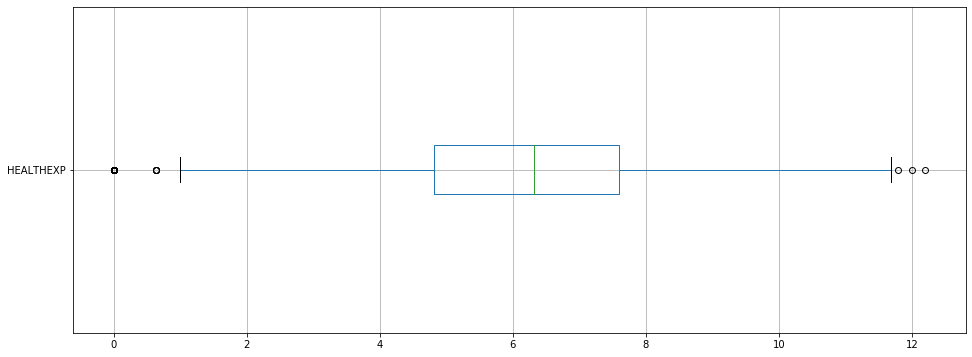

In [13]:
# Check boxplot of target variable after logarithmic transformation
plt.figure(figsize = (16, 6))
data[["HEALTHEXP"]].boxplot(vert = False)
plt.show()

---

### 1) For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [14]:
X = data.drop(columns = "HEALTHEXP")
y = data["HEALTHEXP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [15]:
# Prepare model
not_cat_cols_list = ["POVCAT15", "RTHLTH31", "MNHLTH31"]
categorical_features = get_categorical_features(X, not_cat_cols_list)

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 76, 
                                    max_depth = 5,
                                    min_samples_split = 2,
                                    min_samples_leaf = 5,
                                    random_state = 123)

reg_1 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])


# Fit model
reg_1.fit(X_train, y_train)


# Check results
y_pred_train = reg_1.predict(X_train)
y_pred_test = reg_1.predict(X_test)

print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  2.11944521662311  | MAE:  1.5674767723421807  | R^2:  0.41243823163874405 

Test: 
RMSE:  2.196901260792911  | MAE:  1.6340930212299125  | R^2:  0.35590178167582687 



---

### 2) Calculate permutational variable importance for the selected model

In [16]:
pvi_1 = calculate_pvi(reg_1, X_train, y_train)

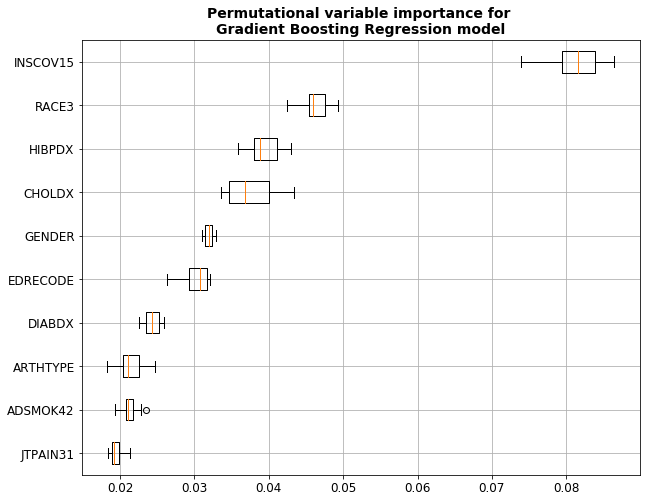

In [20]:
plot_pvi_boxplots(pvi_1, 10, X_train, "Gradient Boosting Regression model", "images/pvi01")

---

### 3) Train three or more candidate models (different variables, different transformations, different model structures) and compare ranking of important features between these models. Are they similar or different?

1) Added **StandardScaler** for numeric variables.

In [18]:
# Prepare model
not_cat_cols_list = ["POVCAT15", "RTHLTH31", "MNHLTH31"]
categorical_features = get_categorical_features(X, not_cat_cols_list)
numerical_features= [f for f in X.columns if f not in categorical_features]

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

numerical_transformer = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 76, 
                                    max_depth = 5,
                                    min_samples_split = 2,
                                    min_samples_leaf = 5,
                                    random_state = 123)

reg_2 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])


# Fit model
reg_2.fit(X_train, y_train)


# Check results
y_pred_train = reg_2.predict(X_train)
y_pred_test = reg_2.predict(X_test)

print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  2.036189044346683  | MAE:  1.5057966529875142  | R^2:  0.4576928489558483 

Test: 
RMSE:  2.1693008747211544  | MAE:  1.607861853928006  | R^2:  0.37198415044718547 



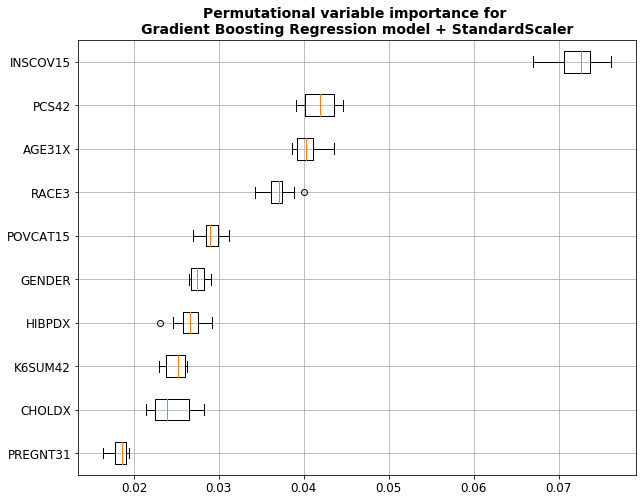

In [21]:
pvi_2 = calculate_pvi(reg_2, X_train, y_train)
plot_pvi_boxplots(pvi_2, 10, X_train, "Gradient Boosting Regression model + StandardScaler", "images/pvi02")

2) Added **MinMaxScaler** for numeric variables.

In [22]:
# Prepare model
not_cat_cols_list = ["POVCAT15", "RTHLTH31", "MNHLTH31"]
categorical_features = get_categorical_features(X, not_cat_cols_list)
numerical_features= [f for f in X.columns if f not in categorical_features]

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

numerical_transformer = Pipeline(
    steps = [
        ("scaler", MinMaxScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 76, 
                                    max_depth = 5,
                                    min_samples_split = 2,
                                    min_samples_leaf = 5,
                                    random_state = 123)

reg_3 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])


# Fit model
reg_3.fit(X_train, y_train)


# Check results
y_pred_train = reg_3.predict(X_train)
y_pred_test = reg_3.predict(X_test)

print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  2.036189044346683  | MAE:  1.5057966529875142  | R^2:  0.4576928489558483 

Test: 
RMSE:  2.169327406901164  | MAE:  1.6078819724618132  | R^2:  0.3719687881416044 



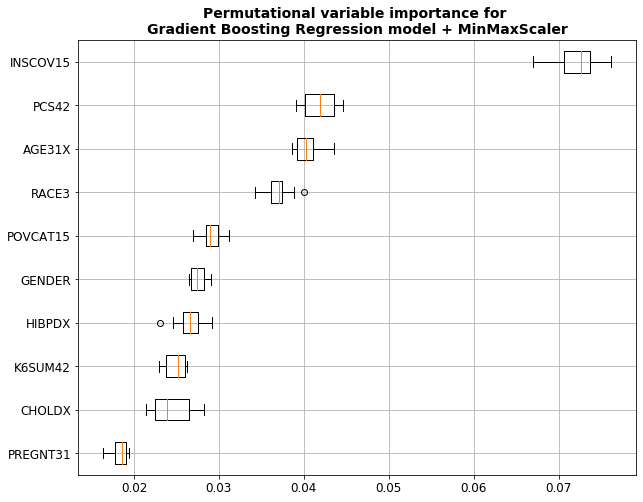

In [23]:
pvi_3 = calculate_pvi(reg_3, X_train, y_train)
plot_pvi_boxplots(pvi_3, 10, X_train, "Gradient Boosting Regression model + MinMaxScaler", "images/pvi03")

3) Changed regressor to **Random Forest**, added **StandardScaler**.

In [24]:
# Prepare model
not_cat_cols_list = ["POVCAT15", "RTHLTH31", "MNHLTH31"]
categorical_features = get_categorical_features(X, not_cat_cols_list)
numerical_features= [f for f in X.columns if f not in categorical_features]

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

numerical_transformer = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)

regressor = RandomForestRegressor(random_state = 123)

reg_4 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])


# Fit model
reg_4.fit(X_train, y_train)


# Check results
y_pred_train = reg_4.predict(X_train)
y_pred_test = reg_4.predict(X_test)

print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  0.9203489598507465  | MAE:  0.668027418866138  | R^2:  0.8892065234745461 

Test: 
RMSE:  2.2551071514483505  | MAE:  1.6899156598593776  | R^2:  0.3213194766536951 



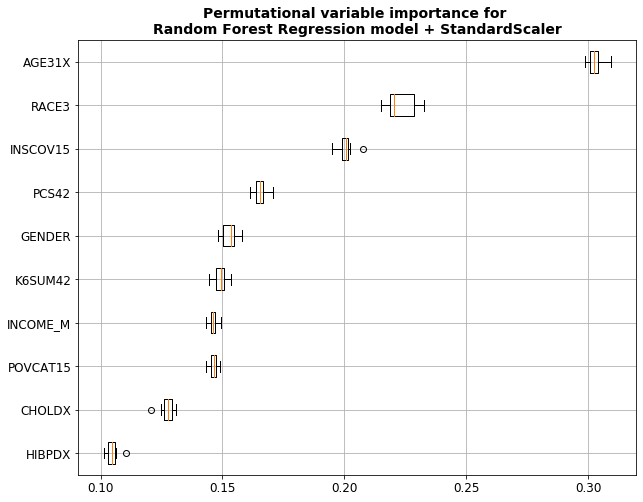

In [25]:
pvi_4 = calculate_pvi(reg_4, X_train, y_train)
plot_pvi_boxplots(pvi_4, 10, X_train, "Random Forest Regression model + StandardScaler", "images/pvi04")

4) Changed regressor to **Linear Regression**, added **StandardScaler**.

In [26]:
# Prepare model
not_cat_cols_list = ["POVCAT15", "RTHLTH31", "MNHLTH31"]
categorical_features = get_categorical_features(X, not_cat_cols_list)
numerical_features= [f for f in X.columns if f not in categorical_features]

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

numerical_transformer = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)

regressor = LinearRegression()

reg_5 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])


# Fit model
reg_5.fit(X_train, y_train)


# Check results
y_pred_train = reg_5.predict(X_train)
y_pred_test = reg_5.predict(X_test)

print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  2.218913000192373  | MAE:  1.669689479516271  | R^2:  0.3559943350091622 

Test: 
RMSE:  2.2123942262179046  | MAE:  1.6646458363332775  | R^2:  0.3467851422728435 



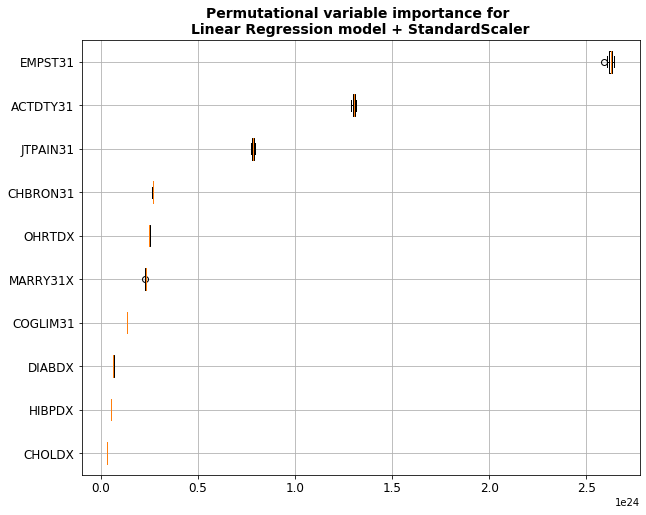

In [27]:
pvi_5 = calculate_pvi(reg_5, X_train, y_train)
plot_pvi_boxplots(pvi_5, 10, X_train, "Linear Regression model + StandardScaler", "images/pvi05")

---